In [1]:
import torch
import os
import matplotlib.pyplot as plt
import imageio
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F
import torchvision
import multiprocessing
import torchvision.transforms as T
import torch.nn as nn

In [2]:
# Hyperparemeters
IMG_SIZE = 128
EPOCHS = 20
BATCH_SIZE  = 4
NUM_WORKERS = int(multiprocessing.cpu_count() / 2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class ContractingBlock(nn.Module):

    def __init__(self, in_chs, out_chs, str_conv = False, mp=True):
        super(ContractingBlock,self).__init__()

        self.conv1 = nn.Conv2d(in_chs,out_chs, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_chs)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_chs,out_chs, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_chs)
        self.relu2 = nn.ReLU(inplace=True)

        self.maxpool  = nn.MaxPool2d(kernel_size=2,stride=2)
        self.str_conv = nn.Conv2d(out_chs, out_chs, kernel_size=2, stride=2)

        self.pooling_flag  = mp
        self.str_conv_flag  = str_conv

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        skip = x
        if self.pooling_flag:
            x = self.maxpool(x)
        if self.str_conv_flag:
            x = self.str_conv(x)

        return x, skip

class ExpandingBlock(nn.Module):

    def __init__(self, in_chs, out_chs, trans_conv):
        super(ExpandingBlock,self).__init__()

        self.conv2d_tr = nn.ConvTranspose2d(in_chs, in_chs // 2, kernel_size=2, stride=2)
        self.upsample  = nn.Upsample(scale_factor = 2, mode='bilinear') # one of ``'nearest'``,``'linear'``, ``'bilinear'``, ``'bicubic'`` and ``'trilinear'``. Default: ``'nearest'``
        self.conv2d    = nn.Conv2d(in_chs, in_chs //2, kernel_size=1) # After upsample only

        self.conv1 = nn.Conv2d(in_chs, out_chs,kernel_size=3,padding=1) # 512,256
        self.bn1   = nn.BatchNorm2d(out_chs)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_chs, out_chs, kernel_size=3, padding=1) # 256,256
        self.bn2   = nn.BatchNorm2d(out_chs)
        self.relu2 = nn.ReLU(inplace=True)
        self.trans_conv_flag = trans_conv

    def forward(self,x,skip):
        if self.trans_conv_flag:
            x = self.conv2d_tr(x)
        else:
            x = self.upsample(x)
            x = self.conv2d(x)

        x = torch.cat((x,skip),dim = 1) # dimension 1 is the channel

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class CustomUNet(nn.Module):

    def __init__(self, in_channels, out_channels, str_conv, trans_conv, mp):
        super(CustomUNet,self).__init__()

        self.contract1 = ContractingBlock(in_channels,32, str_conv, mp)
        self.contract2 = ContractingBlock(32,64, str_conv, mp)
        self.contract3 = ContractingBlock(64,128,str_conv, mp)
        self.contract4 = ContractingBlock(128,256, str_conv, mp)
        self.contract5 = ContractingBlock(256,512, str_conv=False, mp=False)

        self.expand1 = ExpandingBlock(512, 256, trans_conv)
        self.expand2 = ExpandingBlock(256, 128, trans_conv)
        self.expand3 = ExpandingBlock(128, 64, trans_conv)
        self.expand4 = ExpandingBlock(64, 32, trans_conv)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self,x):
        x,skip1 = self.contract1(x)
#         print("-->",x.size(), skip1.size())

        x,skip2 = self.contract2(x)
#         print(x.size(), skip2.size())

        x,skip3 = self.contract3(x)
#         print(x.size(), skip3.size())

        x,skip4 = self.contract4(x)
#         print(x.size(), skip4.size())

        x,skip5 = self.contract5(x)
#         print(x.size(), skip5.size())

        x = self.expand1(x,skip4)
#         print(x.size())

        x = self.expand2(x,skip3)
#         print(x.size())

        x = self.expand3(x,skip2)
#         print(x.size())

        x = self.expand4(x,skip1)
#         print(x.size())

        x = self.final_conv(x)
#         print(x.size())
        return x

In [4]:
custom_unet = CustomUNet(in_channels=3, out_channels=3, str_conv=True, trans_conv=False, mp = np.True_)
custom_unet

CustomUNet(
  (contract1): ContractingBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (str_conv): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
  )
  (contract2): ContractingBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [5]:
working_dir = r'./'

trans = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE), interpolation=T.InterpolationMode.BICUBIC),
    transforms.ToTensor()
])

# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", transform= trans,download=True)
pets_test = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation",transform=trans, download=True)

100%|██████████| 791918971/791918971 [00:47<00:00, 16523073.70it/s]


Extracting OxfordPets/train/oxford-iiit-pet/images.tar.gz to OxfordPets/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 8525455.84it/s] 


Extracting OxfordPets/train/oxford-iiit-pet/annotations.tar.gz to OxfordPets/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:47<00:00, 16789749.62it/s]


Extracting OxfordPets/test/oxford-iiit-pet/images.tar.gz to OxfordPets/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 8661249.45it/s] 


Extracting OxfordPets/test/oxford-iiit-pet/annotations.tar.gz to OxfordPets/test/oxford-iiit-pet


In [6]:
from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2
# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2


class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)

        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if

        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

In [7]:
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"


def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(device),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
    ]),
    post_transform=T.Compose([
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([4, 3, 128, 128]), torch.Size([4, 1, 128, 128]))

In [8]:
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR
def train_unet(epochs, unet, loss_fn, device, train_dataloader, test_dataloader):
    train_losses,test_losses = [],[]

    # scaler = GradScaler()
    optimizer = torch.optim.Adam(unet.parameters(), lr=1e-2, eps=1e-09)
    lr_scheduler = OneCycleLR(optimizer, max_lr=1e-2, total_steps=epochs * len(train_dataloader), pct_start=5 / epochs ,anneal_strategy="linear", div_factor=100.0, final_div_factor=100.0, three_phase=True)


    for epoch in tqdm(range(epochs)):

        unet.train()
        train_loss = 0
        for batch, (X,y) in enumerate(train_dataloader):
            # with autocast():
            x,y = X.to(device), y.to(device)
            y_pred = unet(X)

            loss = loss_fn(y_pred,y.squeeze(1))
            train_loss += loss.item()

            optimizer.zero_grad()
            # scaler.scale(loss).backward()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
        train_loss = train_loss / len(train_dataloader)

        # test model
        unet.eval()
        test_loss = 0

        with torch.inference_mode():
            for batch, (X,y) in enumerate(test_dataloader):
                X,y = X.to(device), y.to(device)
                y_pred = unet(X)

                loss = loss_fn(y_pred,y.squeeze(1))
                test_loss += loss.item()

            test_loss = test_loss / len(test_dataloader)

        print(f"Epoch: {epoch+1} train_loss: {train_loss}  test_loss: {test_loss} ")
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    return train_losses, test_losses

In [9]:
# define losses
cross_entropy_fn = nn.CrossEntropyLoss()

def dice_loss_fn(pred,target,n_classes=3):
    smooth = 0.001
    pred = F.softmax(pred,dim=1).float().flatten(0,1)
    target = F.one_hot(target, n_classes).squeeze(1).permute(0, 3, 1, 2).float().flatten(0,1)
    assert pred.size() == pred.size(), "sizes do not match"

    intersection = 2 * (pred * target).sum(dim=(-1, -2))
    union = pred.sum(dim=(-1, -2)) + target.sum(dim=(-1, -2))
    dice = (intersection + smooth) / ( union + smooth)

    return 1 - dice.mean()

**MP(MaxPooling) + CR (CRoss Entropy) + Tr(Transposed Convolution)**

In [10]:
unet = CustomUNet(in_channels=3, out_channels=3, str_conv=False, trans_conv=True, mp = True).to(device)

train_losses,test_losses = train_unet(EPOCHS, unet, cross_entropy_fn, device, train_dataloader = pets_train_loader,test_dataloader = pets_test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 train_loss: 0.6611229756280131  test_loss: 0.5704013193127636 
Epoch: 2 train_loss: 0.5291907374301682  test_loss: 0.6097954501416168 
Epoch: 3 train_loss: 0.4693559521890205  test_loss: 0.4962507870397277 
Epoch: 4 train_loss: 0.44435688542283097  test_loss: 0.467545586993232 
Epoch: 5 train_loss: 0.4162201541921367  test_loss: 0.42048435989353394 
Epoch: 6 train_loss: 0.3931655659785737  test_loss: 0.3579298325840684 
Epoch: 7 train_loss: 0.35350523385340754  test_loss: 0.34567756392467514 
Epoch: 8 train_loss: 0.3176203616125428  test_loss: 0.3222105841199038 
Epoch: 9 train_loss: 0.2834202462564344  test_loss: 0.2978128388864932 
Epoch: 10 train_loss: 0.24521161537293507  test_loss: 0.2812589292530141 
Epoch: 11 train_loss: 0.22836059250099502  test_loss: 0.2840429239039977 
Epoch: 12 train_loss: 0.22578058787014174  test_loss: 0.2811717228854404 
Epoch: 13 train_loss: 0.2250942568173227  test_loss: 0.28023000543608384 
Epoch: 14 train_loss: 0.22218906272850605  test_loss:

In [12]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)

    # Set a larger figure size
    plt.figure(figsize=(12, 6))  # Adjust the width and height as needed

    # Plot train losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_losses, label='Test Loss', color='orange')
    plt.title('Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plot
    plt.show()


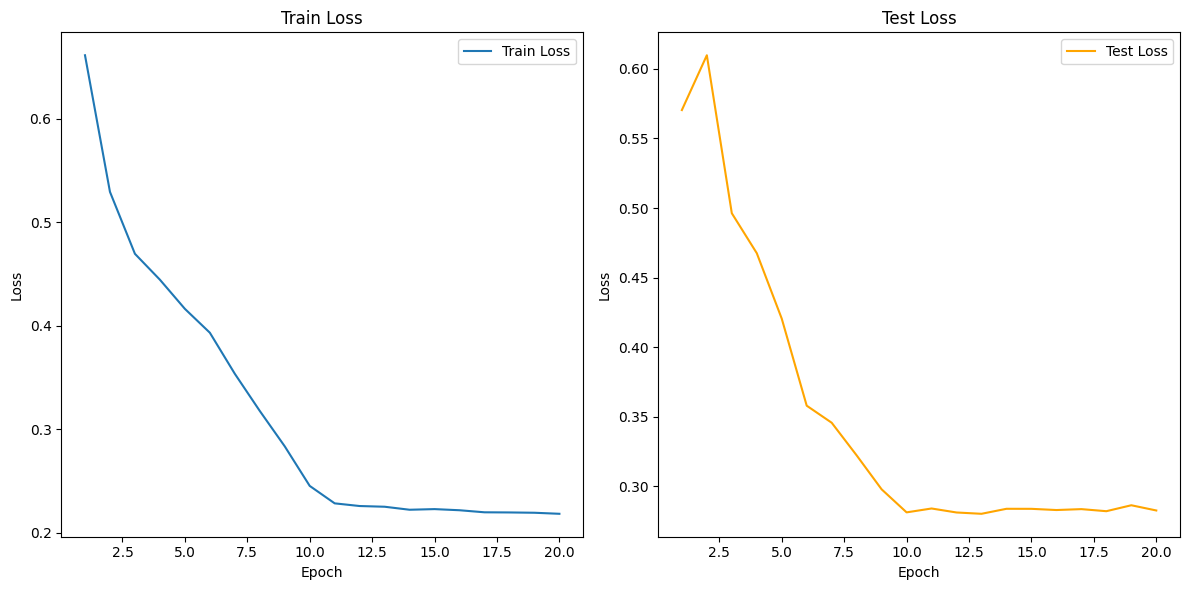

In [12]:
plot_losses(train_losses, test_losses)

**MP(MaxPooling) + DL (Dice Loss) + Tr(Transposed Convolution)**

In [13]:
unet = CustomUNet(in_channels=3, out_channels=3, str_conv=False, trans_conv=True, mp = True).to(device)

train_losses,test_losses = train_unet(EPOCHS, unet, dice_loss_fn, device, train_dataloader = pets_train_loader,test_dataloader = pets_test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 train_loss: 0.3798566615451937  test_loss: 0.37132979744400074 
Epoch: 2 train_loss: 0.30160413682460785  test_loss: 0.3115563866619451 
Epoch: 3 train_loss: 0.283949683541837  test_loss: 0.2625698512805573 
Epoch: 4 train_loss: 0.278678024009518  test_loss: 0.2833584958691483 
Epoch: 5 train_loss: 0.26896305349857913  test_loss: 0.2642441903583884 
Epoch: 6 train_loss: 0.2547768364781919  test_loss: 0.22768906395160035 
Epoch: 7 train_loss: 0.23584686867568805  test_loss: 0.22783582019650078 
Epoch: 8 train_loss: 0.2204397725670234  test_loss: 0.2050382898134344 
Epoch: 9 train_loss: 0.20410125255584716  test_loss: 0.2002520189176198 
Epoch: 10 train_loss: 0.18674141039019046  test_loss: 0.18337927638575402 
Epoch: 11 train_loss: 0.1789198081130567  test_loss: 0.18112158619500454 
Epoch: 12 train_loss: 0.17784029336079307  test_loss: 0.1797888536079257 
Epoch: 13 train_loss: 0.17738503761913466  test_loss: 0.18095869364821573 
Epoch: 14 train_loss: 0.17604086010352424  test_l

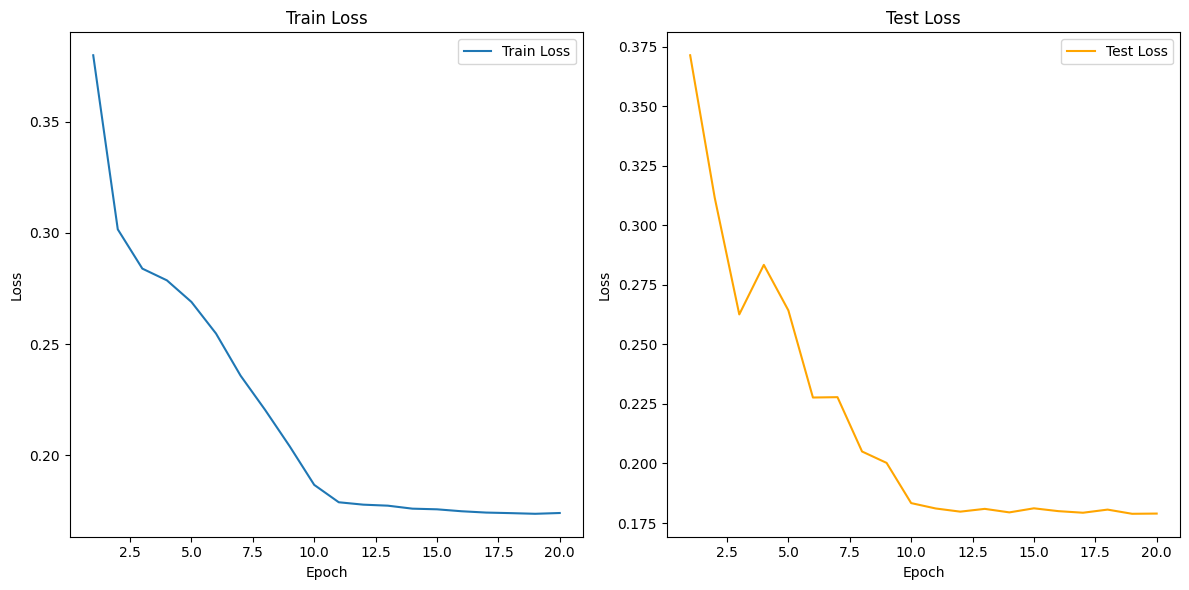

In [14]:
plot_losses(train_losses, test_losses)

**StrConv(Strided Convolution) + CL (Cross Entropy Loss) + Tr(Transposed Convolution)**

In [15]:
unet = CustomUNet(in_channels=3, out_channels=3, str_conv=True, trans_conv=True, mp = False).to(device)

train_losses,test_losses = train_unet(EPOCHS, unet, cross_entropy_fn, device, train_dataloader = pets_train_loader,test_dataloader = pets_test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 train_loss: 0.6675550589418929  test_loss: 0.60880528135562 
Epoch: 2 train_loss: 0.5454201046215451  test_loss: 0.5303197684241276 
Epoch: 3 train_loss: 0.5062045363952284  test_loss: 0.5288633848652081 
Epoch: 4 train_loss: 0.4733613993162694  test_loss: 0.48906411035777697 
Epoch: 5 train_loss: 0.4474350932013729  test_loss: 0.6507809456916676 
Epoch: 6 train_loss: 0.4193981905346331  test_loss: 0.45910260910756706 
Epoch: 7 train_loss: 0.3826625333370074  test_loss: 0.3940116048086443 
Epoch: 8 train_loss: 0.3485008587817783  test_loss: 0.3510395188558206 
Epoch: 9 train_loss: 0.31739263944327833  test_loss: 0.30508273709281336 
Epoch: 10 train_loss: 0.2778669691361163  test_loss: 0.29193387235756274 
Epoch: 11 train_loss: 0.257475351623219  test_loss: 0.29187177244192375 
Epoch: 12 train_loss: 0.255981056926691  test_loss: 0.293306654388154 
Epoch: 13 train_loss: 0.252828027162215  test_loss: 0.2905135626350743 
Epoch: 14 train_loss: 0.2530765497895039  test_loss: 0.29100

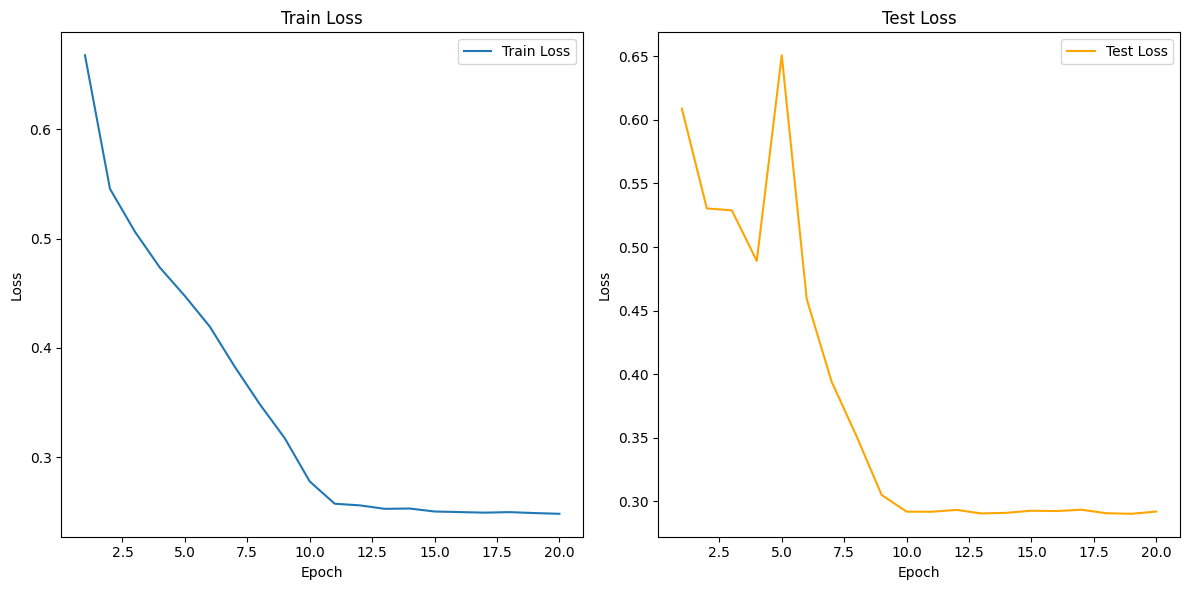

In [16]:
plot_losses(train_losses, test_losses)

**StrConv(Strided Convolution) + DL (Dice Entropy Loss) + Up(Up Sampling)**

In [10]:
unet = CustomUNet(in_channels=3, out_channels=3, str_conv=True, trans_conv=False, mp = False).to(device)

train_losses,test_losses = train_unet(EPOCHS, unet, dice_loss_fn, device, train_dataloader = pets_train_loader,test_dataloader = pets_test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 train_loss: 0.39003261392531186  test_loss: 0.42392307954935726 
Epoch: 2 train_loss: 0.3113824318284574  test_loss: 0.30883965227339005 
Epoch: 3 train_loss: 0.2978960363113362  test_loss: 0.2896622095362553 
Epoch: 4 train_loss: 0.28454231127448704  test_loss: 0.28966195085988844 
Epoch: 5 train_loss: 0.2809768697489863  test_loss: 0.2676447016351363 
Epoch: 6 train_loss: 0.2651003741699716  test_loss: 0.23884220690768787 
Epoch: 7 train_loss: 0.24867805916330088  test_loss: 0.22392985880504765 
Epoch: 8 train_loss: 0.23210258075724477  test_loss: 0.221700194094955 
Epoch: 9 train_loss: 0.2189521654792454  test_loss: 0.21446105182041011 
Epoch: 10 train_loss: 0.19903542140255803  test_loss: 0.19128483352058592 
Epoch: 11 train_loss: 0.18854633161555165  test_loss: 0.18950975895707123 
Epoch: 12 train_loss: 0.18687704276779424  test_loss: 0.18722889249361158 
Epoch: 13 train_loss: 0.18625012053095777  test_loss: 0.18834818383447485 
Epoch: 14 train_loss: 0.18508830711893412  

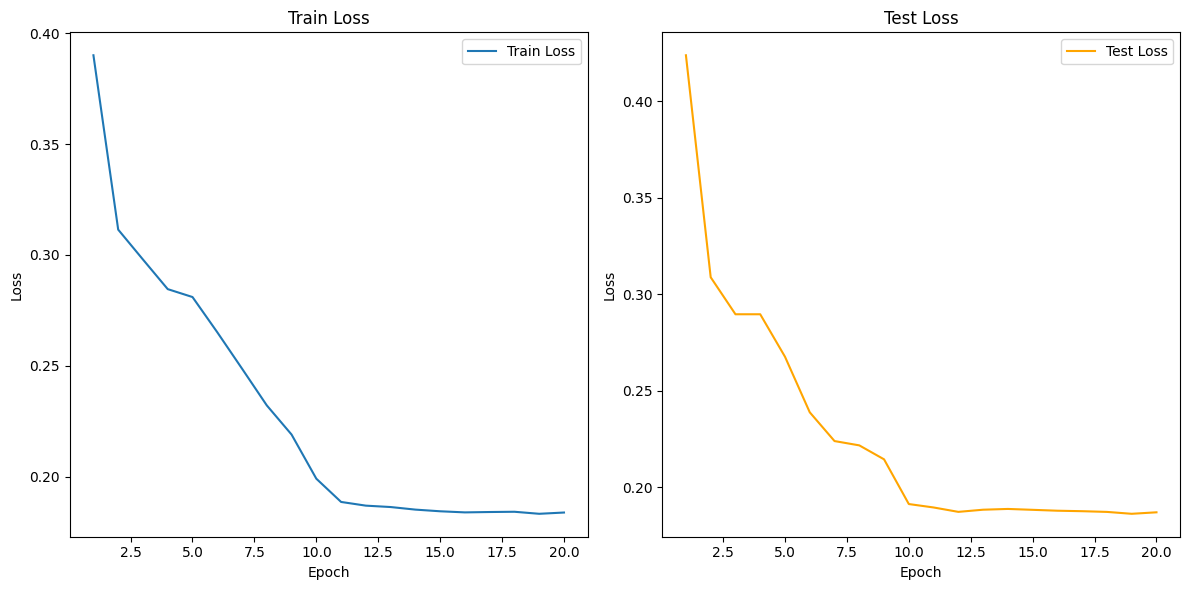

In [13]:
plot_losses(train_losses, test_losses)